## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [1]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Downloading...
From: https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:00<00:00, 190MB/s]


In [2]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=2d1f11bd-1d77-42e9-9ad0-d7e3dcf6db97
To: /content/coco_captions.npy
100% 415M/415M [00:03<00:00, 137MB/s]


In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

In [41]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [42]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [43]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [44]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [45]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [46]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [47]:
def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    accuracy = 0
    for i, pre in enumerate(predict):
        references = real[i]
        score = bleu_score.sentence_bleu(references, pre)
        accuracy += score
    return accuracy/len(predict)

# **Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation.**

In [48]:
index_dimension = image_embeddings.shape[1]
num_nearest_neighbors = 1



index_dimension = image_embeddings.shape[1]
num_nearest_neighbors = 1


quantizer = faiss.IndexFlatL2(index_dimension)


nlist_ivfflat = 256
index = faiss.IndexIVFFlat(quantizer, index_dimension, nlist_ivfflat, faiss.METRIC_L2)

index.train(image_embeddings)
index.add(image_embeddings)

predicted_captions = []
k = 1

batch_size = 128

for i in range(0, len(image_embeddings), 1):

    query_images = image_embeddings[i:i+1]

    _, indices = index.search(query_images, k)

    selected_captions = [captions[j] for j in indices.flatten()]

    weights = np.ones(len(selected_captions))

    query_vectors = np.sum(caption_embeddings[indices.flatten()], axis=1)

    query_vector = np.average(query_vectors, axis=0, weights=weights.flatten())

    _, predicted_caption_index = index.search(np.array([query_vector]), 1)
    predicted_caption = captions[predicted_caption_index[0][0]][1]

    predicted_captions.append(predicted_caption)

print(f"Results for k={k}: Accuracy = {accuracy(predicted_captions,captions)}")


Results for k=1: Accuracy = 0.6335614631786879


# **Try a few options for k. Record your observations.**

In [49]:
k_values = [10, 5, 3, 4, 1]

index_dimension = image_embeddings.shape[1]

quantizer = faiss.IndexFlatL2(index_dimension)

nlist_ivfflat = 256
index = faiss.IndexIVFFlat(quantizer, index_dimension, nlist_ivfflat, faiss.METRIC_L2)

index.train(image_embeddings)
index.add(image_embeddings)

for k in k_values:
    predicted_captions = []

    batch_size = 128

    for i in range(0, len(image_embeddings), 1):
        query_images = image_embeddings[i:i+1]

        _, indices = index.search(query_images, k)

        selected_captions = [captions[j] for j in indices.flatten()]

        weights = np.ones(len(selected_captions))

        query_vectors = np.sum(caption_embeddings[indices.flatten()], axis=1)

        query_vector = np.average(query_vectors, axis=0, weights=weights.flatten())

        _, predicted_caption_index = index.search(np.array([query_vector]), 1)
        predicted_caption = captions[predicted_caption_index[0][0]][1]

        predicted_captions.append(predicted_caption)

    print(f"Results for k={k}: Accuracy = {accuracy(predicted_captions,captions)}")


Results for k=10: Accuracy = 0.546993231300687
Results for k=5: Accuracy = 0.5623548465470877
Results for k=3: Accuracy = 0.5777490086331396
Results for k=4: Accuracy = 0.5699385495456851
Results for k=1: Accuracy = 0.6335614631786879


# **Observations on K-Nearest Neighbors Experimentation**

## 1. Effect of k on Accuracy:
   - The accuracy decreases as the value of `k` increases.
   - Accuracy for different values of `k`:
      - k=10: Accuracy = 54.70%
      - k=5: Accuracy = 56.24%
      - k=4: Accuracy = 56.99%
      - k=3: Accuracy = 57.77%
      - k=1: Accuracy = 63.33%

## 2. Computational Time and Large k:
   - Larger values of `k`, such as k=10, lead to increased computational time.
   - There is a trade-off between accuracy and computational cost.

## 3. Optimal k Selection:
   - Balancing accuracy and computational efficiency is crucial when selecting the value of `k`.
   - Smaller values of `k` (e.g., k=1 or k=3) provide higher accuracy.

## 4. Model Sensitivity to Neighborhood Size:
   - The model is sensitive to the choice of `k`, with varying accuracy for different values.
   - Consider the nature of the dataset and task requirements when selecting `k`.

## 5. Recommendation:
   - Further experiments and analyses are recommended to determine the most suitable value of `k`.


# **Using Faiss_Index_Factory**

# **For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2.**

# **Faiss_Index_Factory Using IVF Flat Index:**

In [50]:
index_dimension = image_embeddings.shape[1]
num_nearest_neighbors = 1



index = faiss.index_factory(index_dimension, f"IVF256,Flat")

index.train(image_embeddings)
index.add(image_embeddings)

predicted_captions = []
k = 1

batch_size = 128

for i in range(0, len(image_embeddings), 1):

    query_images = image_embeddings[i:i+1]

    _, indices = index.search(query_images, k)

    selected_captions = [captions[j] for j in indices.flatten()]

    weights = np.ones(len(selected_captions))

    query_vectors = np.sum(caption_embeddings[indices.flatten()], axis=1)

    query_vector = np.average(query_vectors, axis=0, weights=weights.flatten())

    _, predicted_caption_index = index.search(np.array([query_vector]), 1)
    predicted_caption = captions[predicted_caption_index[0][0]][1]

    predicted_captions.append(predicted_caption)

print(f"Accuracy using IVF256,Flat = {accuracy(predicted_captions,captions)}")



Accuracy using IVF256,Flat = 0.6335614631786879


# **Faiss_Index_Factory Using HNSW32 Index:**

In [51]:
index_dimension = image_embeddings.shape[1]
num_nearest_neighbors = 1
index = faiss.index_factory(index_dimension, f"HNSW32")

index.train(image_embeddings)
index.add(image_embeddings)

predicted_captions = []
k = 1

batch_size = 128

for i in range(0, len(image_embeddings), 1):

    query_images = image_embeddings[i:i+1]

    _, indices = index.search(query_images, k)

    selected_captions = [captions[j] for j in indices.flatten()]

    weights = np.ones(len(selected_captions))

    query_vectors = np.sum(caption_embeddings[indices.flatten()], axis=1)

    query_vector = np.average(query_vectors, axis=0, weights=weights.flatten())

    _, predicted_caption_index = index.search(np.array([query_vector]), 1)
    predicted_caption = captions[predicted_caption_index[0][0]][1]

    predicted_captions.append(predicted_caption)

print(f"Accuracy using HNSW32 = {accuracy(predicted_captions,captions)}")


Accuracy using HNSW32 = 0.6743664513704534


# **Faiss_Index_Factory Using HNSW32 Flat Index:**

In [52]:
index_dimension = image_embeddings.shape[1]
num_nearest_neighbors = 1
index = faiss.index_factory(index_dimension, f"HNSW32,Flat")

index.train(image_embeddings)
index.add(image_embeddings)
predicted_captions = []
k = 1

batch_size = 128

for i in range(0, len(image_embeddings), 1):

    query_images = image_embeddings[i:i+1]

    _, indices = index.search(query_images, k)

    selected_captions = [captions[j] for j in indices.flatten()]

    weights = np.ones(len(selected_captions))

    query_vectors = np.sum(caption_embeddings[indices.flatten()], axis=1)

    query_vector = np.average(query_vectors, axis=0, weights=weights.flatten())

    _, predicted_caption_index = index.search(np.array([query_vector]), 1)
    predicted_caption = captions[predicted_caption_index[0][0]][1]

    predicted_captions.append(predicted_caption)

print(f"Accuracy using HNSW32,Flat= {accuracy(predicted_captions,captions)}")


Accuracy using HNSW32,Flat= 0.6743664513704534


# **Observations on Index Factory Testing with Fixed k=1**

## 1. Accuracy Comparison:
   - "hnsw32": Accuracy = 67%
   - "hnsw32,Flat": Accuracy = 67%
   - "IVF256,Flat": Accuracy = 63%

## 2. Speed Comparison:
   - Among the tested configurations, "IVF256,Flat" demonstrates the fastest performance.
   - The ranking in terms of speed is as follows:
     1. "IVF256,Flat"
     2. "hnsw32"
     3. "hnsw32,Flat"

## 3. Summary:
   - The accuracy is comparable between "hnsw32" and "hnsw32,Flat," both achieving 0.6743664513704534.
   - However, "IVF256,Flat" exhibits slightly lower accuracy but is the fastest among the tested configurations.


# **Qualitative study: Visualize five images, their ground truth captions and the predicted caption.**

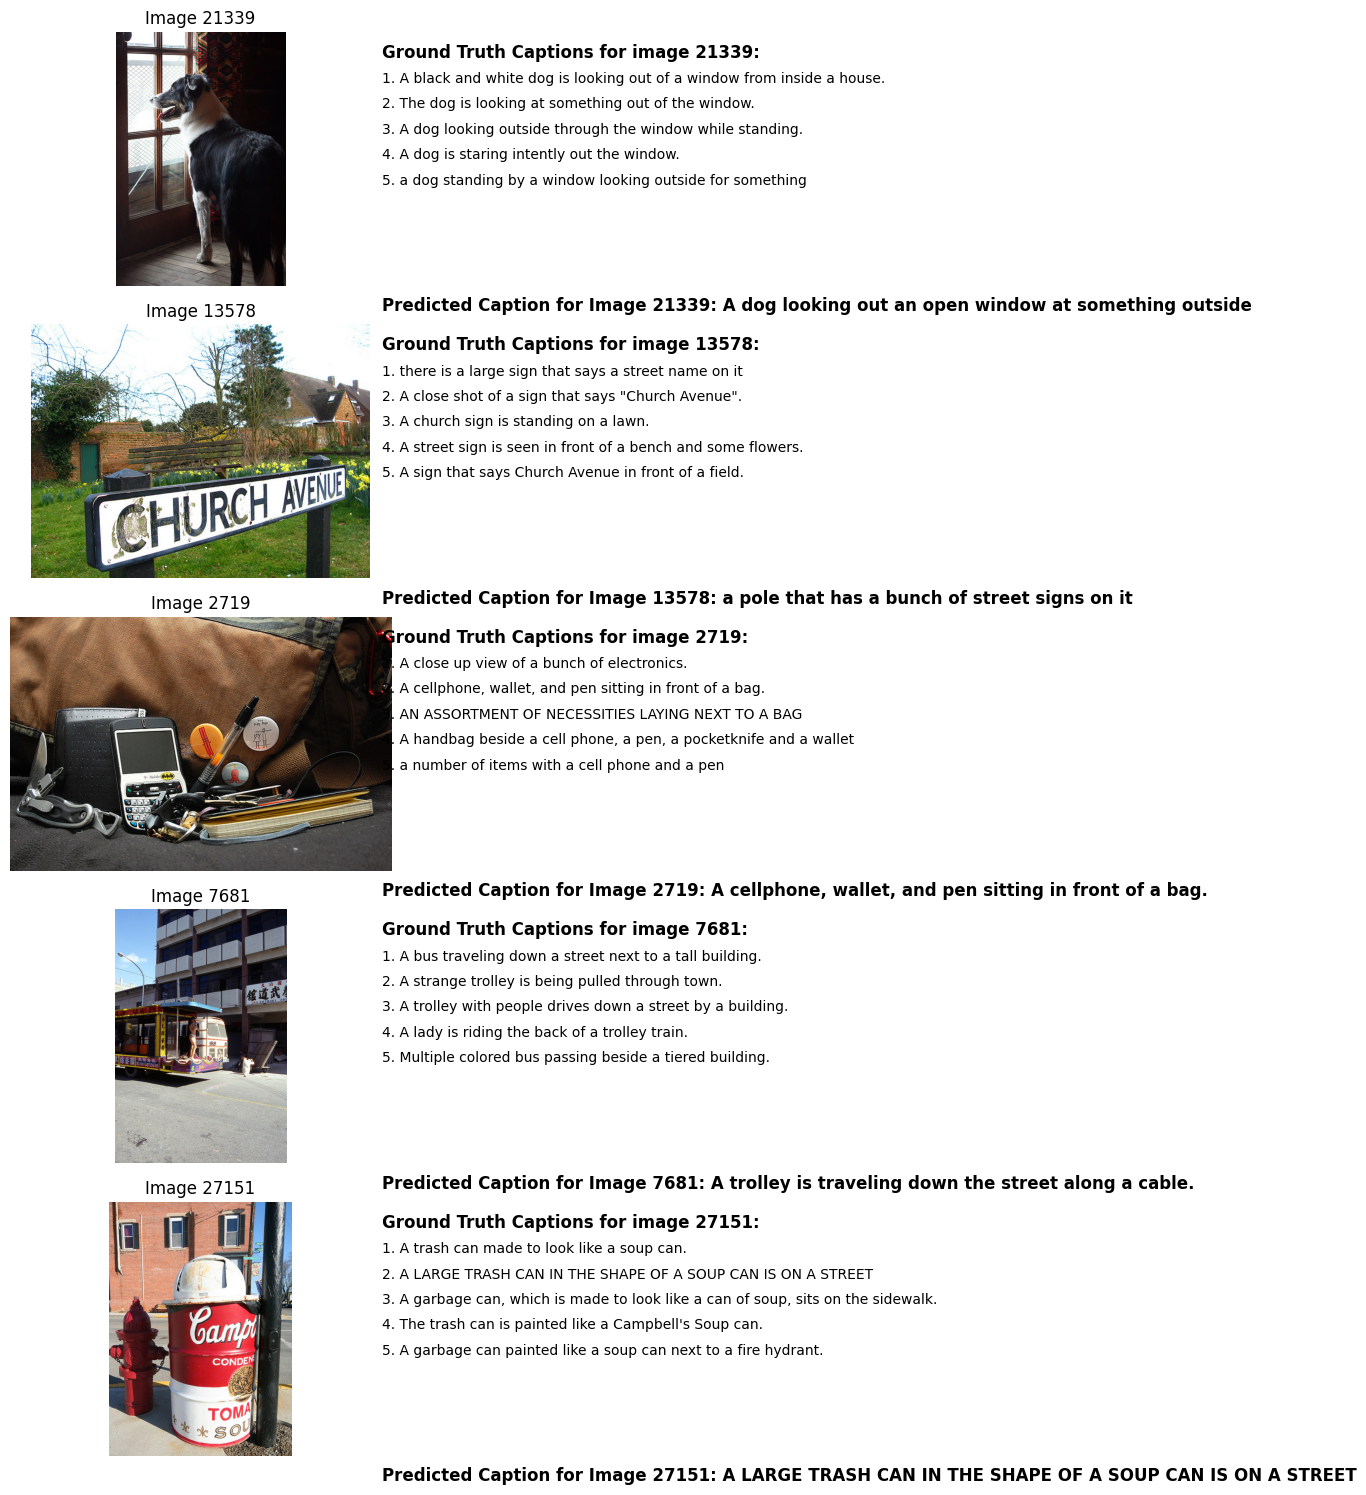

In [53]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

indices_to_visualize = random.sample(range(len(image_embeddings)), 5)

num_rows = 5
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i, idx in enumerate(indices_to_visualize):
    img, target = coco_dset[idx]
    image_path = coco_dset.coco.loadImgs(coco_dset.ids[idx])[0]['file_name']
    ground_truth_captions = captions_np[idx]

    predicted_caption = predicted_captions[idx]

    img_path = '/content/val2014/' + image_path
    img_data = mpimg.imread(img_path)
    axs[i, 0].imshow(img_data)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"Image {idx + 1}")

    axs[i, 1].text(0, 0.9, f"Ground Truth Captions for image {idx + 1}:", fontsize=12, weight='bold')
    for j, caption in enumerate(ground_truth_captions):
        axs[i, 1].text(0, 0.8 - j * 0.1, f"{j + 1}. {caption}", fontsize=10)

    axs[i, 1].text(0, 0.4 - len(ground_truth_captions) * 0.1, f"Predicted Caption for Image {idx + 1}: {predicted_caption}", fontsize=12, weight='bold')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


# **End Scene**